Processing spectrogram for: 221023_1209.wav


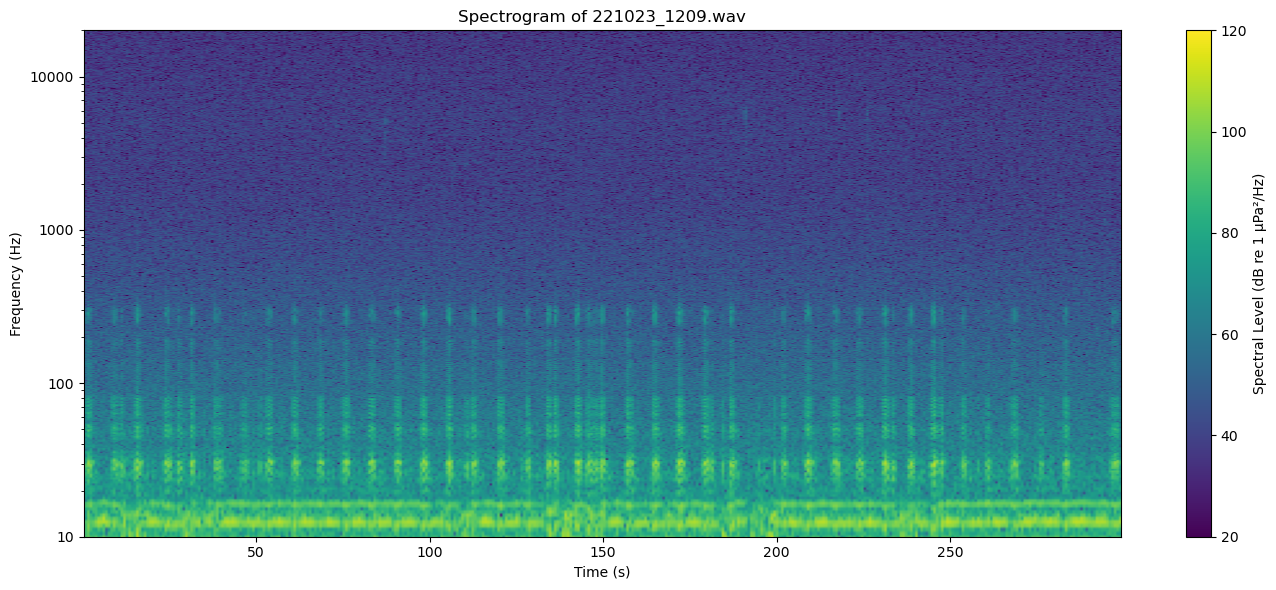

In [18]:
import numpy as np
import soundfile as sf
from scipy.interpolate import interp1d
import pandas as pd
from scipy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
import os
import gc

# paths for data
base_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/ODL Recordings/"
calib_csv_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/Data Sheets/Bins Data for Hydrophone Sensitivity.csv"
wav_filename = "221023_1209.wav"  

# calibration data
calib_df = pd.read_csv(calib_csv_path)
freq_calib = calib_df["Frequency (Hz)"].to_numpy()
sens_calib = calib_df["Sensitivity (dB re 1V/1uPa)"].to_numpy()
sens_calib_gain = sens_calib + 25.0  # Apply preamp gain

# specific WAV file 
wav_path = os.path.join(base_path, wav_filename)
if os.path.isfile(wav_path):
    print(f"Processing spectrogram for: {wav_filename}")
    signal_raw, fs = sf.read(wav_path)
    N = len(signal_raw)
    freqs = rfftfreq(N, d=1/fs)

    #Interpolation and calibration
    interp_func = interp1d(freq_calib, sens_calib_gain, kind='linear', fill_value='extrapolate')
    sens_interp_dB = interp_func(freqs)
    gain_correction = 10 ** (-sens_interp_dB / 20)

    signal_fft = rfft(signal_raw)
    calibrated_fft = signal_fft * gain_correction
    signal_calibrated = irfft(calibrated_fft)

    # spectrogram details
    NFFT = 65536
    fig, ax = plt.subplots(figsize=(14, 6))
    pxx, freqs_spec, bins_spec, im = ax.specgram(
        signal_calibrated,
        Fs=fs,
        NFFT=NFFT,
        noverlap=NFFT // 2,
        vmin=20,
        vmax=120
    )

    ax.set_title(f"Spectrogram of {wav_filename}")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_yscale("log")
    ax.set_ylim(10, 20000)

    # Format for the y-ticks
    ax.set_yticks([10, 100, 1000, 10000])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(plt.NullFormatter())

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, label="Spectral Level (dB re 1 µPa²/Hz)")
    cbar.ax.yaxis.set_label_position('right')
    plt.tight_layout()

    plt.show()  # shows the plot in Jupyter Notebook

    # CLEAN UPPP avoid memory crash
    del signal_raw, signal_fft, calibrated_fft, signal_calibrated
    del pxx, freqs_spec, bins_spec, im
    del fig, ax, cbar
else:
    print(f"File not found: {wav_path}")


Processing: 221022_0962.wav


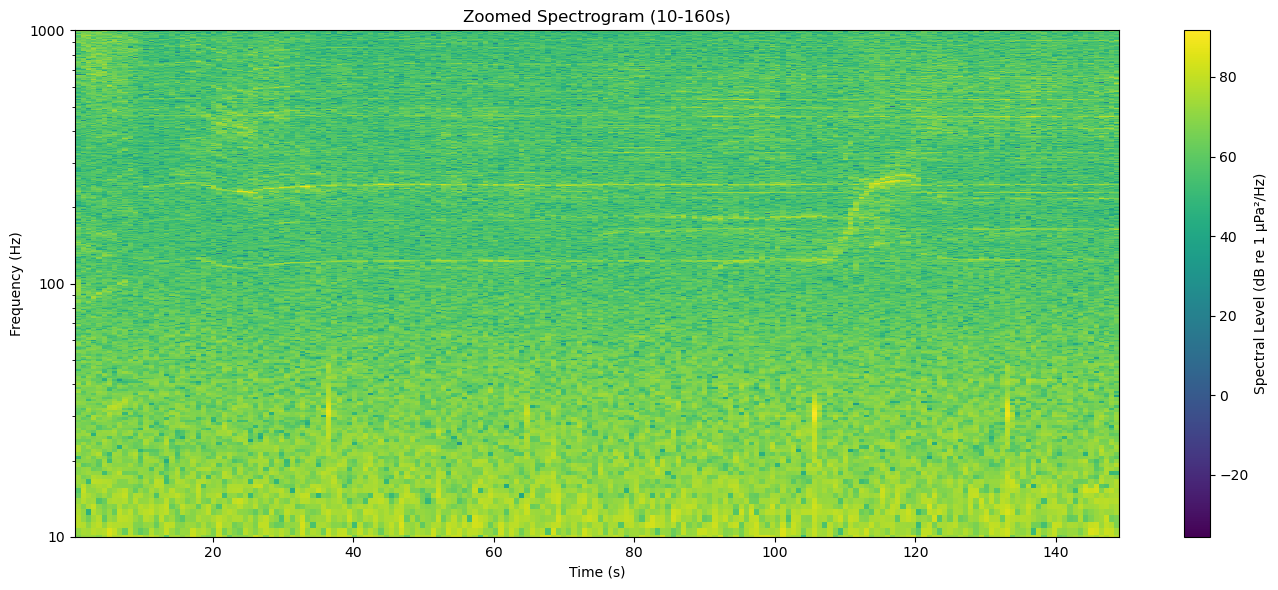

In [15]:
####this is also a spectrogram but we are zooming in to different frequency and changing NFFT quality


import numpy as np
import soundfile as sf
from scipy.interpolate import interp1d
import pandas as pd
from scipy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
import os

# paths for data
base_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/ODL Recordings/"
calib_csv_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/Data Sheets/Bins Data for Hydrophone Sensitivity.csv"
wav_filename = "221022_0962.wav"  

# === Time window to zoom in (adjust these) ===
start_time = 10     # seconds
duration = 150       # seconds
NFFT = 65536                   # smaller FFT = better time resolution

# === Load calibration data ===
calib_df = pd.read_csv(calib_csv_path)
freq_calib = calib_df["Frequency (Hz)"].to_numpy()
sens_calib = calib_df["Sensitivity (dB re 1V/1uPa)"].to_numpy()
sens_calib_gain = sens_calib + 25.0  # Apply preamp gain

# === Process specific WAV file ===
wav_path = os.path.join(base_path, wav_filename)
if os.path.isfile(wav_path):
    print(f"Processing: {wav_filename}")
    signal_raw, fs = sf.read(wav_path)

    # Extract slice
    start_sample = int(start_time * fs)
    end_sample = int((start_time + duration) * fs)
    signal_snippet = signal_raw[start_sample:end_sample]
    N = len(signal_snippet)
    freqs = rfftfreq(N, d=1/fs)

    # === Interpolate and calibrate ===
    interp_func = interp1d(freq_calib, sens_calib_gain, kind='linear', fill_value='extrapolate')
    sens_interp_dB = interp_func(freqs)
    gain_correction = 10 ** (-sens_interp_dB / 20)

    signal_fft = rfft(signal_snippet)
    calibrated_fft = signal_fft * gain_correction
    signal_calibrated = irfft(calibrated_fft)

    # === Plot spectrogram ===
    fig, ax = plt.subplots(figsize=(14, 6))
    pxx, freqs_spec, bins_spec, im = ax.specgram(
        signal_calibrated,
        Fs=fs,
        NFFT=NFFT,
        noverlap=NFFT // 2  # 50% overlap
        # No vmin/vmax — autoscale color
    )

    ax.set_title(f"Zoomed Spectrogram ({start_time}-{start_time + duration}s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_yscale("log")
    ax.set_ylim(10, 1000)  # Avoid low-frequency floor noise

    ax.set_yticks([10, 100, 1000,])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(plt.NullFormatter())

    cbar = fig.colorbar(im, ax=ax, label="Spectral Level (dB re 1 µPa²/Hz)")
    cbar.ax.yaxis.set_label_position('right')
    plt.tight_layout()
    plt.show()
else:
    print(f"File not found: {wav_path}")
